In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from helpers import log, load_csv, save_csv
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.feature_selection import SelectKBest, mutual_info_regression
# import xgboost as xgb
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.neural_network import MLPRegressor
# from sklearn.ensemble import RandomForestRegressor, VotingRegressor
import seaborn as sns
# import optuna
from catboost import CatBoostRegressor

In [2]:
data_directory = "Fantasy-Premier-League/data"
training_data_dir = os.path.join(data_directory, "training_data")
training_file = os.path.join(training_data_dir, "MID_players.csv")
mid_data = load_csv(training_file)
mid_data = mid_data[mid_data["minutes"] >= 60]
mid_data["atk_def_diff"] = mid_data["own_attack"] - mid_data["opponent_defense"]
mid_data["def_atk_diff"] = mid_data["own_defense"] - mid_data["opponent_attack"]

<Figure size 1400x700 with 0 Axes>

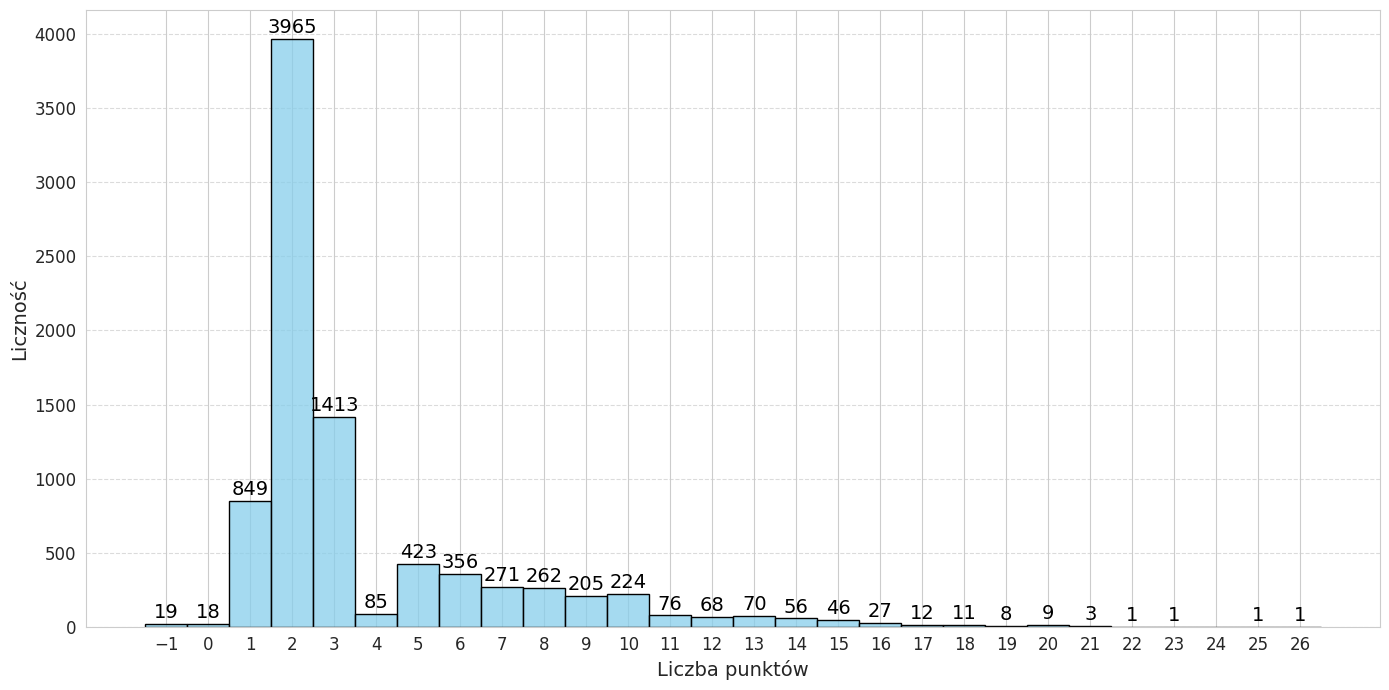

In [3]:
# Plot points for midfielders
sns.set_style("whitegrid")

plt.figure(figsize=(14, 7))

min_points = int(mid_data['total_points'].min())
max_points = int(mid_data['total_points'].max())
plt.figure(figsize=(14, 7))
ax = sns.histplot(mid_data['total_points'], bins=range(min_points, max_points + 2), discrete=True, color='skyblue', edgecolor='black')

for patch in ax.patches:
    height = patch.get_height()
    if height > 0: 
        ax.text(
            patch.get_x() + patch.get_width() / 2,
            height + 40,
            f"{int(height)}",
            ha="center",
            fontsize=14,
            color="black"
        )

plt.xlabel("Liczba punktów", fontsize=14)
plt.ylabel("Liczność", fontsize=14)

plt.xticks(ticks=range(min_points, max_points + 1), fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [4]:
stats_points = mid_data["total_points"].describe()
variance = mid_data["total_points"].var()
median_points = mid_data["total_points"].median()

print("Statystyki punktów pomocników:")
print(stats_points)
print(f"Wariancja: {variance:.2f}")
print(f"Mediana punktów zdobytych przez pomocników: {median_points}")

Statystyki punktów pomocników:
count    8480.000000
mean        3.659080
std         3.183343
min        -1.000000
25%         2.000000
50%         2.000000
75%         5.000000
max        26.000000
Name: total_points, dtype: float64
Wariancja: 10.13
Mediana punktów zdobytych przez pomocników: 2.0


In [5]:
rolling_candidates = [
    "shots", "key_passes", "expected_goals", "expected_assists", "goals_scored",
    "bps", "ict_index", "influence", "creativity", "threat", "assists", "total_points",
    "clean_sheets", "yellow_cards"
]
rolling_periods = [4, 16]

for feature in rolling_candidates:
    for period in rolling_periods:
        sma_column = f"{feature}_rolling_{period}"
        group = mid_data.groupby("Unique_ID")[feature]
        
        mid_data[sma_column] = group.apply(
            lambda x: x.shift(1).rolling(window=period, min_periods=1).mean()
        ).reset_index(level=0, drop=True)

for feature in rolling_candidates:
    for period in rolling_periods:
        sma_column = f"{feature}_rolling_{period}"
        mid_data[sma_column] = mid_data[sma_column].bfill()

other_available = [
    "value", "atk_def_diff", "def_atk_diff",
    "opponent_xGA_rolling_4",	"opponent_deep_allowed_rolling_4",
    'team_xG_rolling_4', 'team_deep_rolling_4',
    'opponent_xGA_rolling_16', 'opponent_deep_allowed_rolling_16',
    "own_attack", "opponent_defense", "own_defense", "opponent_attack",
    'team_xG_rolling_16', 'team_deep_rolling_16'
]

In [6]:
# target = mid_data["total_points"]  # Zmienna docelowa

# possible_features = pd.concat([
#     mid_data[[f"{col}_rolling_{period}" for col in rolling_candidates for period in rolling_periods] + other_available],
# ], axis=1)
# select_k_best = SelectKBest(score_func=lambda X, y: mutual_info_regression(X, y, random_state=42), k=49)
# pipeline = Pipeline([
#     ("select_k_best", select_k_best)
# ])

# pipeline.fit(possible_features, target)

# all_feature_names = possible_features.columns.tolist()

# selected_features = pipeline.named_steps["select_k_best"].get_support(indices=True)

# best_feature_names = [all_feature_names[i] for i in selected_features]
# selected_features = best_feature_names
# print(best_feature_names)

RMSE: 3.0246
MAE: 2.1255


/tmp/ipykernel_1368095/3412448719.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_8_features.values, y=top_8_features.index, palette="viridis")


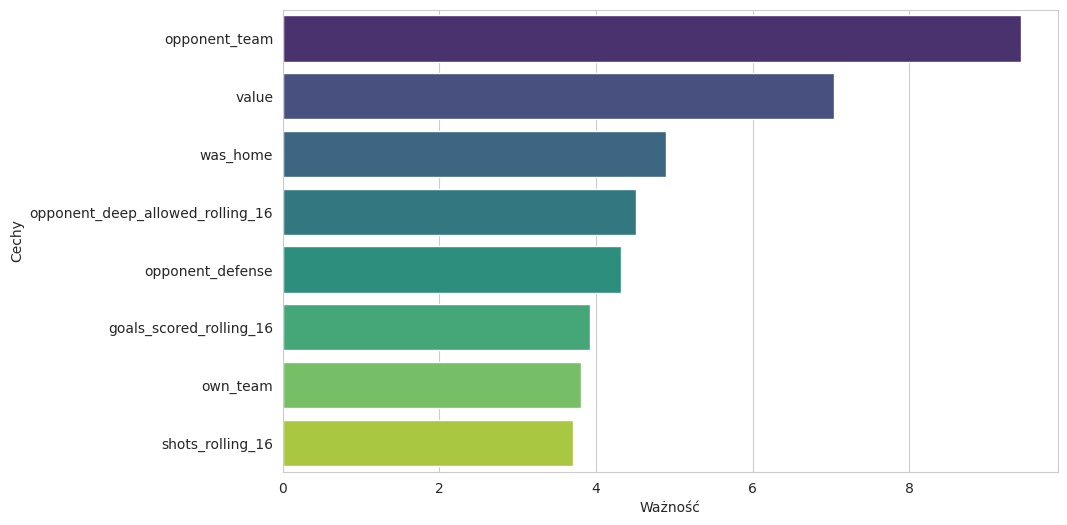

Model saved at: models/mid_prediction_model.json


In [7]:
categorical = ["own_team", "opponent_team", "was_home"]
mid_data[categorical] = mid_data[categorical].astype("category")
selected_features = ['shots_rolling_4', 'shots_rolling_16', 'key_passes_rolling_16', 'expected_goals_rolling_4', 
                     'expected_goals_rolling_16', 'expected_assists_rolling_4', 'goals_scored_rolling_4', 
                     'goals_scored_rolling_16', 'ict_index_rolling_4', 'ict_index_rolling_16', 'influence_rolling_16', 
                     'creativity_rolling_16', 'threat_rolling_4', 'threat_rolling_16', 'assists_rolling_4', 'assists_rolling_16', 
                     'total_points_rolling_4', 'total_points_rolling_16', 'value', 'atk_def_diff', 'def_atk_diff', 
                     'opponent_xGA_rolling_4', 'team_xG_rolling_4', 'team_deep_rolling_4', 'opponent_xGA_rolling_16', 
                     'opponent_deep_allowed_rolling_16', 'own_attack', 'opponent_defense', 'own_defense', 'team_xG_rolling_16', 
                     'team_deep_rolling_16']

X = pd.concat([mid_data[selected_features], mid_data[categorical]], axis=1)
y = mid_data["total_points"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor(
    iterations=277, 
    learning_rate=0.010516953857740385, 
    depth=10, 
    l2_leaf_reg=0.8936669141168816,
    bagging_temperature=4.131030175393649, 
    subsample=0.8624874028874272, 
    random_strength=0.7935354345723039,
    random_seed=42,
    verbose=0,
    cat_features=categorical,
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

importances = model.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

top_8_features = feature_importances.head(8)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_8_features.values, y=top_8_features.index, palette="viridis")
plt.xlabel('Ważność')
plt.ylabel('Cechy')
plt.show()

models_folder = "models"
os.makedirs(models_folder, exist_ok=True)
model_path = os.path.join(models_folder, "mid_prediction_model.json")
model.save_model(model_path)
print(f"Model saved at: {model_path}")